### Import Libraries and Read in Data

In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict
import spacy
import nltk
import string
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
# from contractions import CONTRACTION_MAP
import unicodedata
from wordcloud import STOPWORDS
import gc
import re
import string
import operator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [94]:
us_resp_df = pd.read_csv("../input/2020-vassar-datafest-josh-data/us_covid_resp.csv")
twt_2009 = pd.read_csv("../input/2020-vassar-datafest-josh-data/tweets_in_2009_with_dep_labels.csv")
twt_covid = pd.read_csv("../input/2020-vassar-datafest-josh-data/tweets_in_2020_covid_with_dep_labels.csv")

### N-Gram Visualization of COVID Depression Tweets

In [104]:
twt_covid_dep = twt_covid.copy()[twt_covid.majority_voting_predicted_depression == 1]

In [151]:
twt_covid_non_dep = twt_covid.copy()[twt_covid.majority_voting_predicted_depression != 1]

In [95]:
# Generating ngrams

def ngram_gen(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [105]:
unigrams = defaultdict(int) # Unigrams
bigrams = defaultdict(int)
trigrams = defaultdict(int)
five_grams = defaultdict(int)

for tweet in twt_covid_dep['clean_content']:
    for word in ngram_gen(tweet):
        unigrams[word] += 1
        
for tweet in twt_covid_dep['clean_content']:
    for word in ngram_gen(tweet, n_gram=2):
        bigrams[word] += 1

In [106]:
for tweet in twt_covid_dep['clean_content']:
    for word in ngram_gen(tweet, n_gram=3):
        trigrams[word] += 1
        
# for tweet in twt_covid_dep['clean_content']:
#     for word in ngram_gen(tweet,  n_gram=5):
#         five_grams[word] += 1
        
unigrams_df = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])
bigrams_df = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])
trigrams_df = pd.DataFrame(sorted(trigrams.items(), key=lambda x: x[1])[::-1])
# five_grams_df = pd.DataFrame(sorted(five_grams.items(), key=lambda x: x[1])[::-1])

Text(0.5, 1.0, 'Top 20 most frequent Unigrams in covid-depression tweets')

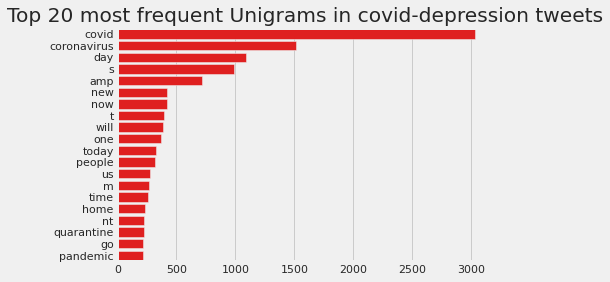

In [123]:
# Unigram Visualization

sns.barplot(y=unigrams_df[0].values[:20], x=unigrams_df[1].values[:20], color='red')

plt.title("Top 20 most frequent Unigrams in covid-depression tweets")

Text(0.5, 1.0, 'Top 20 most frequent Bigrams in covid-depression tweets')

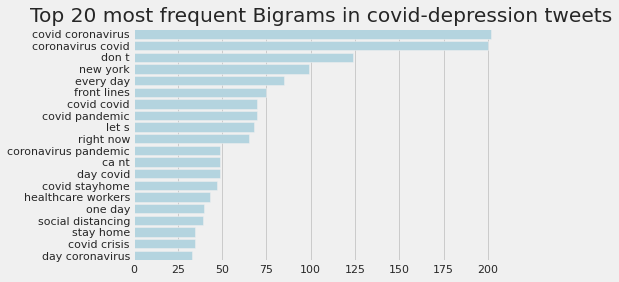

In [124]:
# Bigram Visualization

sns.barplot(y=bigrams_df[0].values[:20], x=bigrams_df[1].values[:20], color='lightblue')

plt.title("Top 20 most frequent Bigrams in covid-depression tweets")

Text(0.5, 1.0, 'Top 20 most frequent Trigrams in covid-depression tweets')

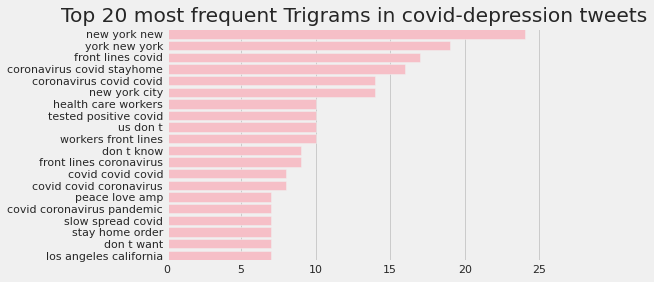

In [125]:
# Trigrams Visualization

sns.barplot(y=trigrams_df[0].values[:20], x=trigrams_df[1].values[:20], color='lightpink')

plt.title("Top 20 most frequent Trigrams in covid-depression tweets")

#### TF-IDF weighted WordCloud for COVID-Depression Tweets

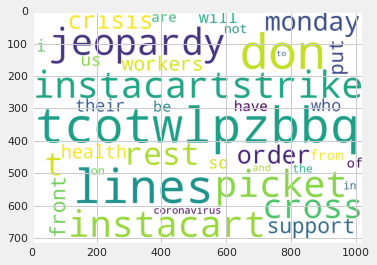

In [128]:
### Real New Data WordCloud based on TFIDF

# %%time

# import sys
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from collections import defaultdict

def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}

    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms

stemmer = PorterStemmer() # Stemmer for reducing terms to root form 

stemmed_corpus = []       # For storing the stemmed tokens 

original_corpus = []      # For storing the non-stemmed tokens


for contents in twt_covid_dep['clean_content']:                # Iterate over title column

    tokens = word_tokenize(contents)     # Extract tokens

    stemmed = [stemmer.stem(token) for token in tokens] # Stem tokens


    stemmed_corpus.append(stemmed)    # Store stemmed document

    original_corpus.append(tokens)    # Store original document
    
dictionary = Dictionary(stemmed_corpus) # Build the dictionary

# Get the surface form for each stemmed word

counts = get_common_surface_form(original_corpus, stemmer)

# Convert to vector corpus

vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]

# Train TF-IDF model

tfidf = TfidfModel(vectors)

# Get TF-IDF weights

weights = tfidf[vectors[0]]

# Replace term IDs with human consumable strings

weights = [(counts[dictionary[pair[0]]], pair[1]) for pair in weights]

# Initialize the cloud

wc = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720,
    stopwords=stopwords.words('english')
)

# Generate the cloud
plt.imshow(wc.fit_words(dict(weights)))

### OLS Regression

How do different tweet features impact the likelihood of that tweet being a depressing tweet?

In [171]:
twt_covid['is_quote'].replace({True: 1, False : 0}, inplace=True)
twt_covid['is_retweet'].replace({True: 1, False : 0}, inplace=True)
twt_covid['verified'].replace({True: 1, False : 0}, inplace=True)

In [173]:
for ft in ['is_quote', 'is_retweet', 'favourites_count','retweet_count','followers_count','friends_count',
              'wc','unique_wc','stop_wc','mean_wl','median_wl','cc','pc']:
    twt_covid[ft] = twt_covid[ft].astype('float64')

In [174]:
### OLS Regression

import statsmodels.api as sm

X = twt_covid[['is_quote','is_retweet','verified','favourites_count','retweet_count','followers_count','friends_count',
              'wc','unique_wc','stop_wc','mean_wl','median_wl','cc','pc']].values # Features

y = twt_covid[['majority_voting_predicted_depression']].values # Dependent Variable

# fit a OLS model with intercept
X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     157.2
Date:                Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:12:51   Log-Likelihood:                -8751.7
No. Observations:               24310   AIC:                         1.753e+04
Df Residuals:                   24296   BIC:                         1.764e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.019     -0.071      0.9

The following 4 variables were statistically significant:

- Word Count
- Unique Word Count
- Character Count
- Punctuation Count

### Gov Reactions... working...?

In [213]:
# Create Increment columns for confirmed cases and deaths
us_resp_df['ConfirmedCasesIncrement'] = us_resp_df.ConfirmedCases.diff()
us_resp_df['ConfirmedDeathsIncrement'] = us_resp_df.ConfirmedDeaths.diff()

In [237]:
# Because we only have tweets from March 29th - April 30

us_resp_df_post03_29 = us_resp_df.copy()[(us_resp_df.Date >= '2020-03-29') & (us_resp_df.Date <= '2020-04-30')]

Text(0, 0.5, 'Percentage(%)')

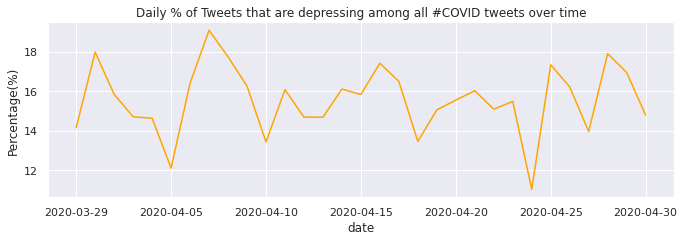

In [239]:
plt.figure(figsize=(10,3))
(twt_covid_dep.groupby('date').size() * 100 / twt_covid.groupby('date').size()).plot(color='orange')
plt.title('Daily % of Tweets that are depressing among all #COVID tweets over time')
plt.ylabel('Percentage(%)')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 <a list of 33 Text major ticklabel objects>)

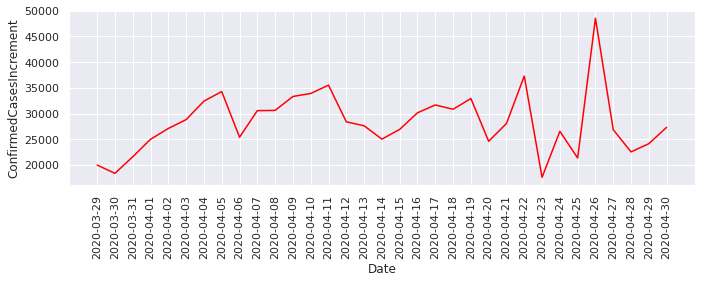

In [241]:
sns.set(rc={'figure.figsize':(10,3)})
sns.lineplot(x='Date',y='ConfirmedCasesIncrement', data=us_resp_df_post03_29, color='red')
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 <a list of 33 Text major ticklabel objects>)

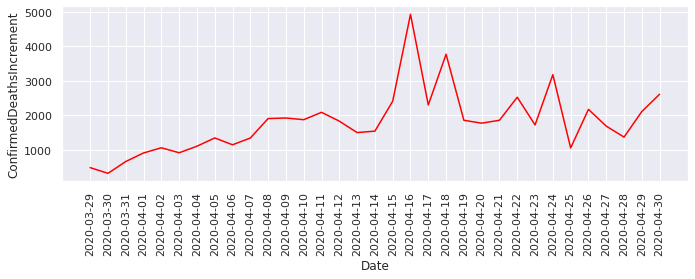

In [243]:
sns.set(rc={'figure.figsize':(10,3)})
sns.lineplot(x='Date',y='ConfirmedDeathsIncrement', data=us_resp_df_post03_29, color='red')
plt.xticks(rotation=90)

Text(0, 0.5, 'USD')

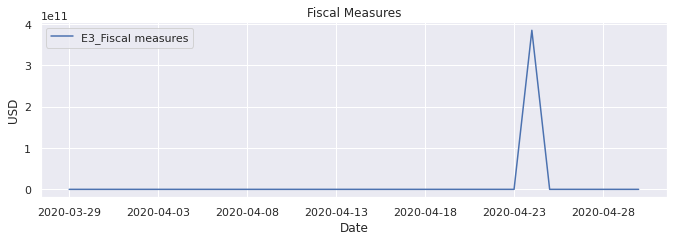

In [244]:
us_resp_df_post03_29.plot(x='Date',y='E3_Fiscal measures', figsize=(10,3))
plt.title('Fiscal Measures')
plt.ylabel('USD')

Text(0, 0.5, 'USD')

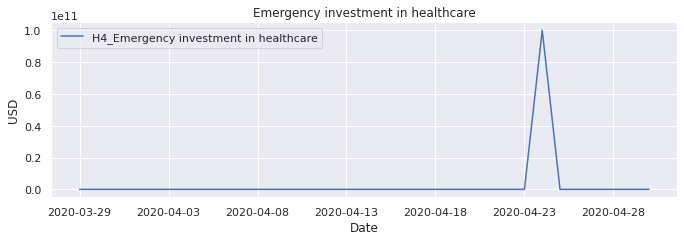

In [245]:
us_resp_df_post03_29.plot(x='Date',y='H4_Emergency investment in healthcare', figsize=(10,3))
plt.title('Emergency investment in healthcare')
plt.ylabel('USD')